## Hierarchical Models for Sports Analytics
### 무엇을 배우나요?
* math에서 모델로
* 모델의 prior를 만들기
* 모델 평가하기
* 모델 개선하기

### Refercence
* https://www.youtube.com/watch?v=Fa64ApS0qig
* https://github.com/fonnesbeck/hierarchical_models_sports_analytics/blob/main/Hierarchical_Models_Sports_Analytics.ipy


### Data preprocessing

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt

import warnings

warnings.filterwarnings("ignore", category=UserWarning)

RANDOM_SEED = 42

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.9.2


In [4]:
baseball_data = pd.read_csv("data/stats_by_player_team.csv")

In [5]:
baseball_data.head()

,bam_id,batter_name,team_id,season,age,name_abbrev,position,bats,pa,hr,avg_ev,avg_la,woba,ops,slg
0,405395,"Pujols, Albert",138,2022,42,STL,DH,R,351,24,91.213178,16.360659,0.381911,0.895218,0.550489
1,405395,"Pujols, Albert",108,2021,41,LAA,DH,R,92,5,90.494658,15.508767,0.264725,0.622093,0.372093
2,405395,"Pujols, Albert",119,2021,41,LAD,DH,R,204,12,90.199245,10.343962,0.318208,0.759337,0.460317
3,408234,"Cabrera, Miguel",116,2021,38,DET,DH,R,526,15,91.287906,9.675895,0.305772,0.701183,0.385593
4,408234,"Cabrera, Miguel",116,2023,40,DET,DH,R,99,0,88.460606,7.199242,0.218162,0.454773,0.202247


In [6]:
baseball_data["label"] = (
    baseball_data.batter_name
    + " ("
    + baseball_data.name_abbrev
    + ") "
    + baseball_data.season.astype(str)
)
baseball_data = baseball_data.rename(columns={"name_abbrev": "team"})

In [7]:
baseball_data.head()

,bam_id,batter_name,team_id,season,age,team,position,bats,pa,hr,avg_ev,avg_la,woba,ops,slg,label
0,405395,"Pujols, Albert",138,2022,42,STL,DH,R,351,24,91.213178,16.360659,0.381911,0.895218,0.550489,"Pujols, Albert (STL) 2022"
1,405395,"Pujols, Albert",108,2021,41,LAA,DH,R,92,5,90.494658,15.508767,0.264725,0.622093,0.372093,"Pujols, Albert (LAA) 2021"
2,405395,"Pujols, Albert",119,2021,41,LAD,DH,R,204,12,90.199245,10.343962,0.318208,0.759337,0.460317,"Pujols, Albert (LAD) 2021"
3,408234,"Cabrera, Miguel",116,2021,38,DET,DH,R,526,15,91.287906,9.675895,0.305772,0.701183,0.385593,"Cabrera, Miguel (DET) 2021"
4,408234,"Cabrera, Miguel",116,2023,40,DET,DH,R,99,0,88.460606,7.199242,0.218162,0.454773,0.202247,"Cabrera, Miguel (DET) 2023"


In [8]:
fitting_subset = baseball_data[baseball_data.season < 2023].dropna()

In [45]:
fitting_subset.drop(["woba", "ops"], axis=1).head()

,bam_id,batter_name,team_id,season,age,team,position,bats,pa,hr,avg_ev,avg_la,slg,label
0,405395,"Pujols, Albert",138,2022,42,STL,DH,R,351,24,91.213178,16.360659,0.550489,"Pujols, Albert (STL) 2022"
1,405395,"Pujols, Albert",108,2021,41,LAA,DH,R,92,5,90.494658,15.508767,0.372093,"Pujols, Albert (LAA) 2021"
2,405395,"Pujols, Albert",119,2021,41,LAD,DH,R,204,12,90.199245,10.343962,0.460317,"Pujols, Albert (LAD) 2021"
3,408234,"Cabrera, Miguel",116,2021,38,DET,DH,R,526,15,91.287906,9.675895,0.385593,"Cabrera, Miguel (DET) 2021"
5,408234,"Cabrera, Miguel",116,2022,39,DET,DH,R,433,5,89.881030,4.958638,0.317380,"Cabrera, Miguel (DET) 2022"


In [12]:
fitting_subset.head()

,bam_id,batter_name,team_id,season,age,team,position,bats,pa,hr,avg_ev,avg_la,woba,ops,slg,label
0,405395,"Pujols, Albert",138,2022,42,STL,DH,R,351,24,91.213178,16.360659,0.381911,0.895218,0.550489,"Pujols, Albert (STL) 2022"
1,405395,"Pujols, Albert",108,2021,41,LAA,DH,R,92,5,90.494658,15.508767,0.264725,0.622093,0.372093,"Pujols, Albert (LAA) 2021"
2,405395,"Pujols, Albert",119,2021,41,LAD,DH,R,204,12,90.199245,10.343962,0.318208,0.759337,0.460317,"Pujols, Albert (LAD) 2021"
3,408234,"Cabrera, Miguel",116,2021,38,DET,DH,R,526,15,91.287906,9.675895,0.305772,0.701183,0.385593,"Cabrera, Miguel (DET) 2021"
5,408234,"Cabrera, Miguel",116,2022,39,DET,DH,R,433,5,89.881030,4.958638,0.276905,0.622230,0.317380,"Cabrera, Miguel (DET) 2022"


In [14]:
print("n of subset = ", len(fitting_subset))
print("n of total = ", len(baseball_data))

n of subset =  1494
n of total =  2023


<Axes: xlabel='hr_rate', ylabel='Count'>

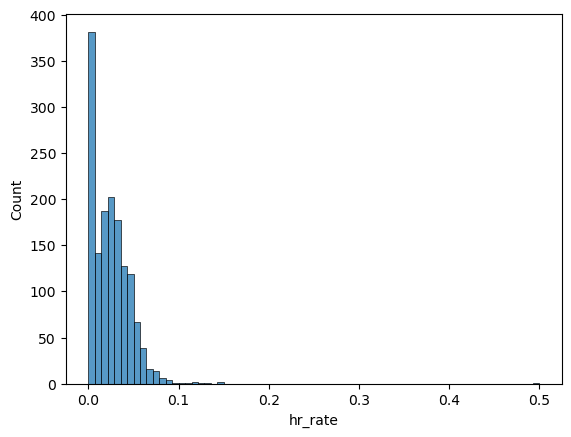

In [15]:
sns.histplot(
    x="hr_rate",
    data=fitting_subset.assign(
        hr_rate=(fitting_subset.hr / fitting_subset.pa).astype(np.float32)
    ),
    bins=70,
) # home run rate

* binomial distribution
$$ y_{i} \approx Binomial(n_{i}, p_{i})$$

### Choosing a prior
* prior for p 
$$ p_{i} = Uniform(0, 1)$$

In [19]:
pa, hr = fitting_subset[["pa", "hr"]].astype(int).values.T
coords = {"batter": fitting_subset.label.values}

In [21]:
pa, hr

(array([351,  92, 204, ..., 194,  45, 156]),
 array([24,  5, 12, ...,  4,  1,  5]))

In [22]:
coords

{'batter': array(['Pujols, Albert (STL) 2022', 'Pujols, Albert (LAA) 2021',
        'Pujols, Albert (LAD) 2021', ..., 'Massey, Michael (KC) 2022',
        'Brennan, Will (CLE) 2022', 'Grissom, Vaughn (ATL) 2022'],
       dtype=object)}

In [26]:
len(coords["batter"])

1494

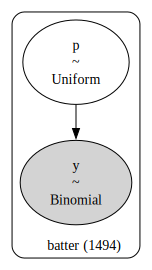

In [27]:
with pm.Model(coords=coords) as uninformative_prior_model: 
    # note that coords specifies the dimensions of the random variables
    # and the data
    p = pm.Uniform("p", 0, 1, dims="batter")
    y = pm.Binomial("y", n=pa, p=p, observed=hr, dims="batter")

pm.model_to_graphviz(uninformative_prior_model)

### Prior predictive checks and sampling
* Notice we are not conditioning on any data here! We are seeing what the model predicts in the absence of data. 
* We can generate data from the prior predictive distribution. This is a good idea to do before fitting any model, as it allows us to check that our model is reasonable and that our inference algorithms are working.
$$p(y) = \int_{\theta}p(y, \theta)d\theta = \int_{\theta}p(y|\theta)p(\theta)d\theta$$


In [28]:
with uninformative_prior_model:
    uninformed_prior_trace = pm.sample_prior_predictive(1000)

Sampling: [p, y]


In [29]:
uninformed_prior_trace

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

<Axes: ylabel='Count'>

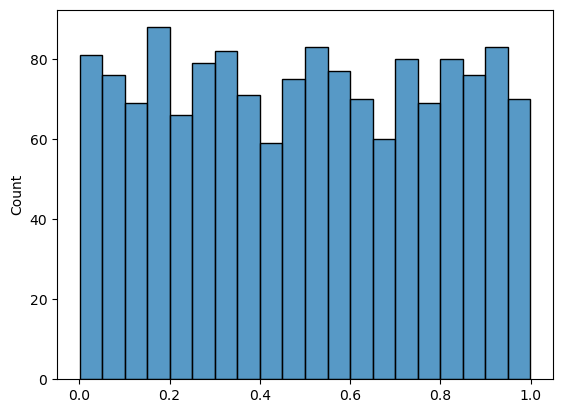

In [30]:
# plot the prior (uninform)
sns.histplot(
    uninformed_prior_trace.prior["p"].sel(chain=[0], draw=[0]).squeeze(), bins=20
)

<Axes: xlabel='y / y'>

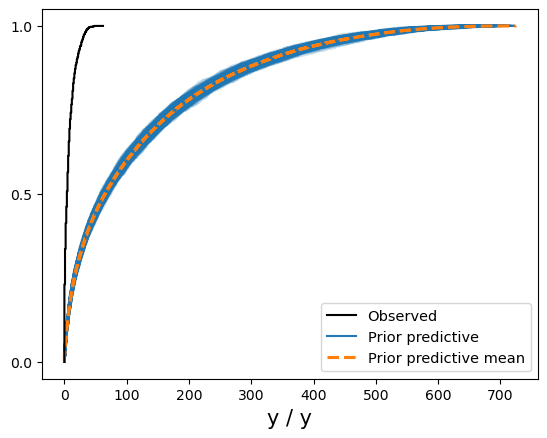

In [31]:
az.plot_ppc(uninformed_prior_trace, group="prior", kind="cumulative")

<Axes: xlabel='hr', ylabel='Density'>

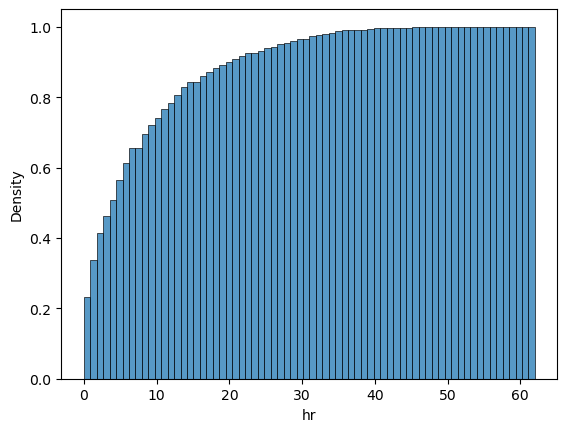

In [42]:
sns.histplot(data=fitting_subset, x="hr", bins=70, cumulative=True, stat="density")
# plt.xlim(0, 700)

### Model fitting with MCMC
* Let's go ahead and estimate our model using Markov chaine Monte Carlo (MCMC); specifically, PyMC will use the NUTS algorithm since all of our parameters are continuous.

In [43]:
with uninformative_prior_model:
    trace = pm.sample(draws=100, tune=100, cores=4, chains=4, random_seed=RANDOM_SEED)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 3 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


### Checking convergence : r_hat
* The R-hat diagnostic uses multiple chains to check for lack of convergence, and is based on the notion that if multiple chains have converged, by definition they should appear very similar to one another; if not, one or more of the chains has failed to converge.
* between-chain varaince (B) and within-chain varaince (W)

$$ B = \frac{n}{m-1}\sum^{m}_{j=1}(\bar\theta_{.j} - \bar\theta_{..})^{2} $$
$$ W = \frac{1}{m}\sum^{m}_{j=1}[\frac{1}{n-1}\sum^{n}_{i=1}(\theta_{ij} - \bar\theta_{.j})^{2}] $$

* m: chains, n: length of chain

$$ \hat{\text{Var}}(\theta|y) = \frac{n-1}{n}W + \frac{1}{n}B$$

* $\hat{\text{Var}}$ : marginal posterior variance
$$ \hat{R} = \sqrt{\frac{\hat{\text{Var}}(\theta|y)}{W}}$$
* $\hat{R}$ : the Gelman-Rubin statistic monitors. If $\hat{R}$ is close to 1, then the chains have converged. Assuming $\theta$ was initialized to arbitrary starting points in each chain, this quantity will overestimate the true marginal posterior variance. At the same time, $W$ will tend to underestimate the within-chain variance early in the sampling run.




In [46]:
az.summary(trace).sort_values("r_hat", ascending=False).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"p[Cain, Lorenzo (MIL) 2022]",0.013,0.009,0.001,0.030,0.000,0.000,907.0,209.0,1.06
"p[White, Eli (TEX) 2021]",0.031,0.012,0.012,0.053,0.001,0.000,344.0,211.0,1.06
"p[Miller, Owen (CLE) 2021]",0.025,0.011,0.007,0.044,0.001,0.000,361.0,88.0,1.06
"p[Walker, Christian (ARI) 2021]",0.025,0.008,0.011,0.039,0.000,0.000,535.0,124.0,1.06
"p[Drury, Brandon (SD) 2022]",0.048,0.016,0.017,0.079,0.001,0.001,454.0,160.0,1.06


* Bulk-ESS(ess_bulk) is useful as a diagnostic for the sampling efficiency in the bulk of the posterior. It is defined as the **effective sample size** for rank normalized values using split chains.

* Tail-ESS(ess_tail) is useful as a diagnostic for the sampling efficiency in the tails of the posterior. It is defined as the **minimum of the effective sample sizes** for 5% and 95% quantiles.

---
Clearly, 100 samples after 100 tuning samples is not sufficient to estimate the posterior distribution. 

In [47]:
with uninformative_prior_model:
    trace = pm.sample(draws=1000, tune=1000, cores=4, chains=4, random_seed=RANDOM_SEED)

# Add samples to the InfrernceData object
uninformed_prior_trace.extend(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


<Axes: title={'center': 'p\nSchwarber, Kyle (PHI) 2022'}, xlabel='Total number of draws', ylabel='ESS'>

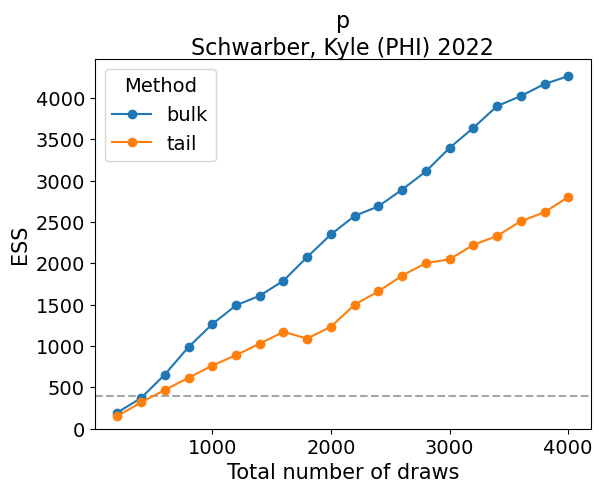

In [48]:
az.plot_ess(
    uninformed_prior_trace,
    var_names=["p"],
    coords={"batter": ["Schwarber, Kyle (PHI) 2022"]},
    kind="evolution",
)

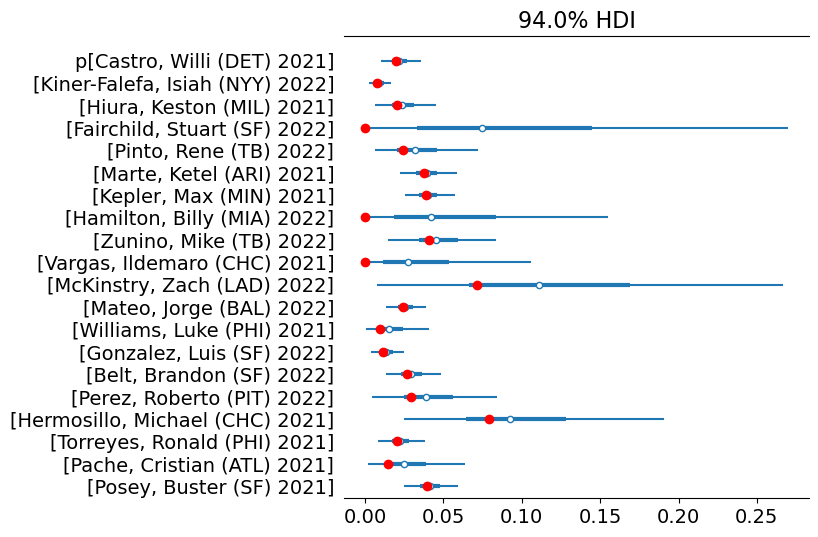

In [53]:
SAMPLE_BATTERS = fitting_subset.sample(n=20, random_state=42).label
obs_rates = (
    baseball_data.set_index("label")
    .loc[SAMPLE_BATTERS]
    .apply(lambda x: x.hr / x.pa, axis=1)
)

(ax,) = az.plot_forest(
    uninformed_prior_trace, coords={"batter": list(SAMPLE_BATTERS)}, combined=True
)

ax.plot(obs_rates[::-1], ax.get_yticks(), "ro", label="Observed rate")

* Sampling was good for all players, but you can see that some are far more uncertain than others, and this uncertainty is related to the number of plate appearances, as we would expect.

In [54]:
uninformed_means = uninformed_prior_trace.posterior.mean(dim=("chain", "draw"))
uninformed_hdi = az.hdi(uninformed_prior_trace)

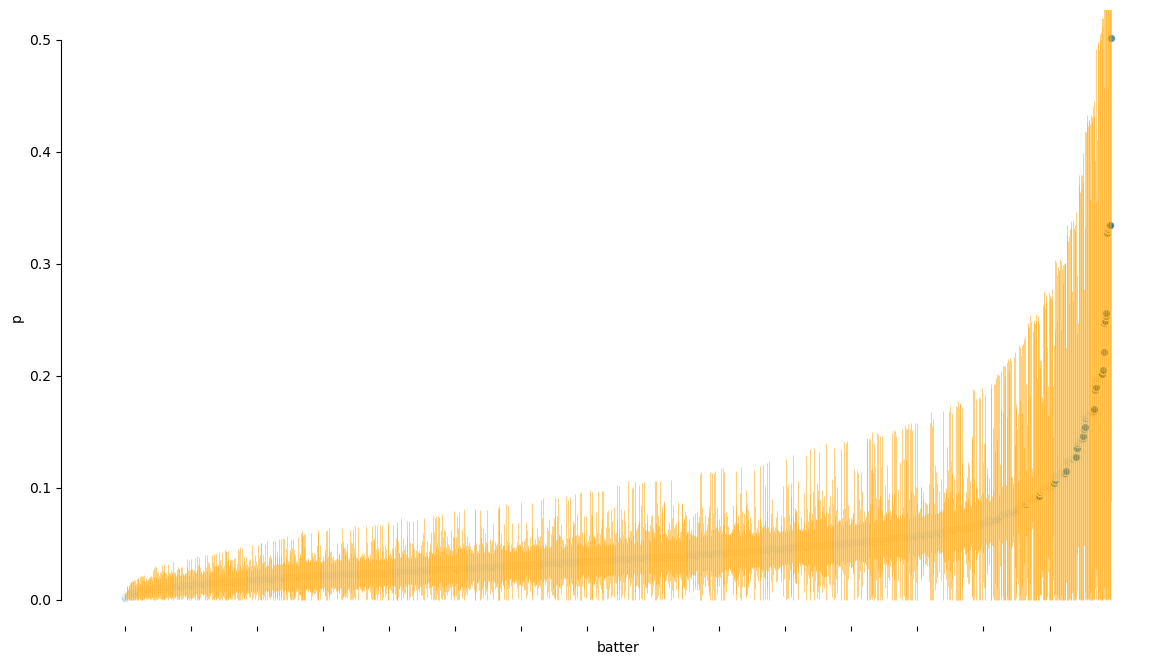

In [61]:
fig, ax = plt.subplots(figsize=(14, 8))

uninformed_means_iter = uninformed_means.sortby("p")
uninformed_hdi_iter = uninformed_hdi.sortby(uninformed_means_iter.p)
ax.vlines(
    np.arange(fitting_subset.shape[0]),
    uninformed_hdi_iter.p.sel(hdi="lower"),
    uninformed_hdi_iter.p.sel(hdi="higher"),
    color="orange",
    alpha=0.6,
    linewidth=0.6,
)
uninformed_means_iter.plot.scatter(x="batter", y="p", ax=ax, alpha=0.8)

ax.set_xticklabels([])
ax.set_xticks([x for x in range(0, len(fitting_subset), 100)])
sns.despine(offset=10, trim=True, bottom=True)

Text(0, 0.5, 'Uncertainty of estimate')

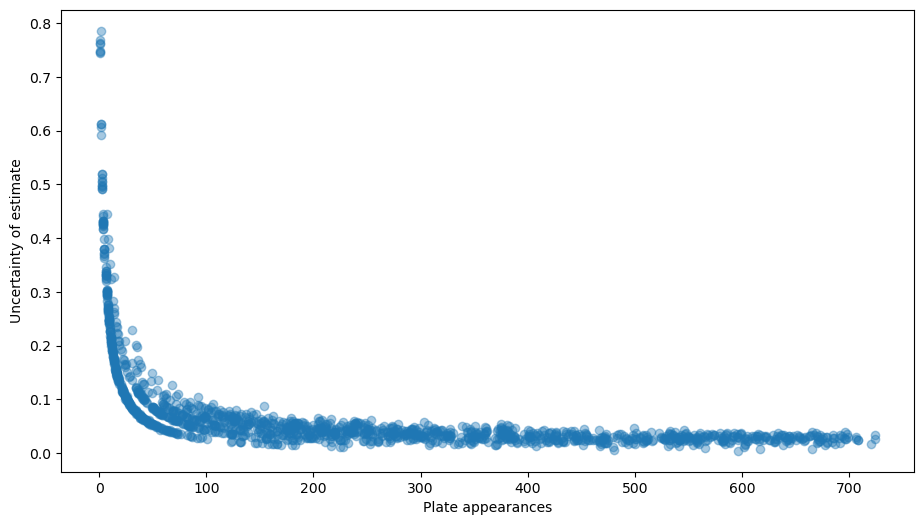

In [62]:
uncertainty = uninformed_hdi.p.sel(hdi="higher") - uninformed_hdi.p.sel(hdi="lower")

plt.figure(figsize=(11, 6))
plt.plot(pa, uncertainty, "o", alpha=0.4)
plt.xlabel("Plate appearances")
plt.ylabel("Uncertainty of estimate")

* This is a classic issue with no-pooling models: when you estimate individuals as being independent from each other, how do you interpret the small-sample-size estimates?

### Posterior Predictive Smapling   
* We can use the posterior predictive distribution to generate data that is consistent with our model and the data we have observed. This is a good way to check that our model is reasonable and that our inference algorithms are working.
$$p(y^{new}|y^{obs}) = \int p(y^{new}|\theta)p(\theta|y^{obs})d\theta$$

In [63]:
with uninformative_prior_model:
    pm.sample_posterior_predictive(uninformed_prior_trace, extend_inferencedata=True)

Sampling: [y]


array([<Axes: xlabel='y / y'>], dtype=object)

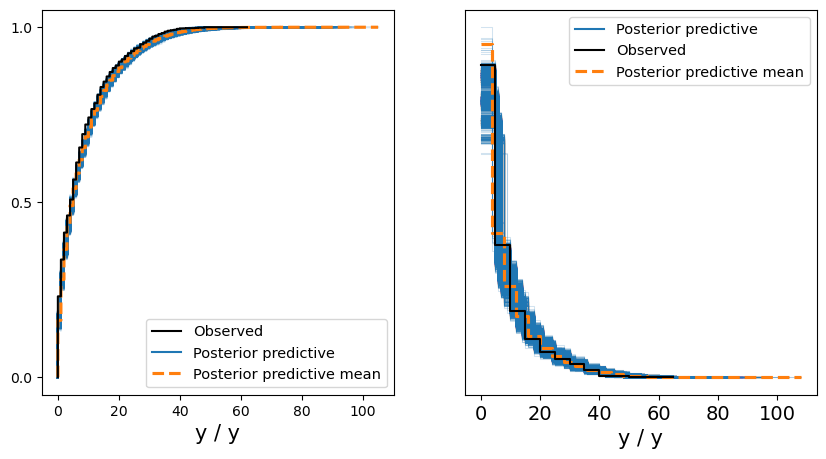

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
az.plot_ppc(uninformed_prior_trace, group="posterior", kind="cumulative", ax=axes[0])
az.plot_ppc(uninformed_prior_trace, group="posterior", ax=axes[1])

* The model fits the dataset reasonably well, though the estiamtes for low-sample size home run rates are not great.

### Informative priors
* chose beta distribution for prior for the binomial distribution.
$$ p_{i} \approx Beta(\alpha, \beta)$$
$$ p(x|\alpha, \beta) = \frac{x^{\alpha-1}(1-x)^{\beta-1}}{B(\alpha, \beta)}$$

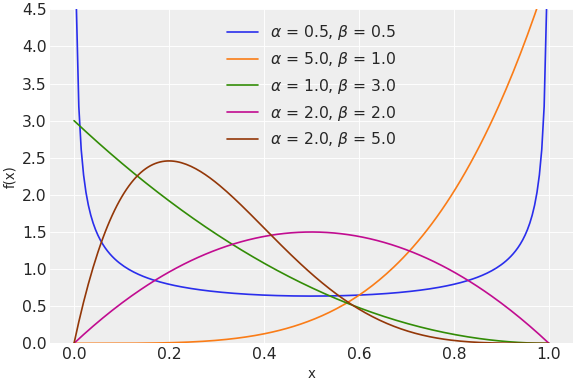
* For exmaple, we might be interested in a beta distribtion with 95% of its probability mass between 0.01 and 0.11. 

In [65]:
pm.find_constrained_prior(
    pm.Beta,
    lower=0.01,
    upper=0.11,
    init_guess={"alpha": 2, "beta": 40},
)

{'alpha': 3.137590660092654, 'beta': 60.555650325086546}

<Axes: ylabel='Probability'>

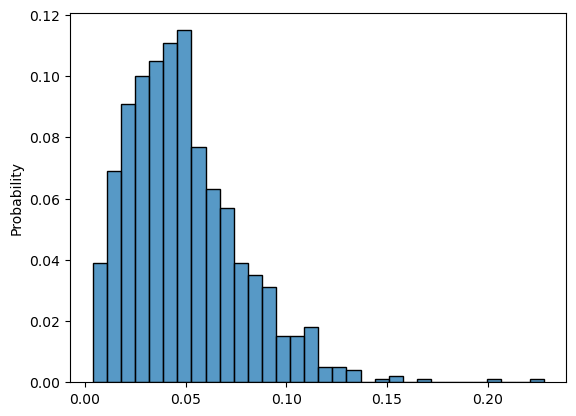

In [68]:
sns.histplot(
    pm.Beta.dist(alpha=3.13, beta=60.55, shape=1000).eval(), stat="probability"
)

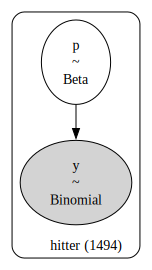

In [72]:
with pm.Model(
    coords={"hitter": fitting_subset.label.values}
) as informative_prior_model:

    beta_params = pm.find_constrained_prior(
        pm.Beta,
        lower=0.005,
        upper=0.09,
        init_guess={"alpha": 2, "beta": 40},
    )

    p = pm.Beta("p", **beta_params, dims="hitter")

    y = pm.Binomial("y", n=pa, p=p, observed=hr, dims="hitter")

pm.model_to_graphviz(informative_prior_model)

In [73]:
with informative_prior_model:
    informed_prior_trace = pm.sample_prior_predictive(1000)

Sampling: [p, y]


<Axes: xlabel='y / y'>

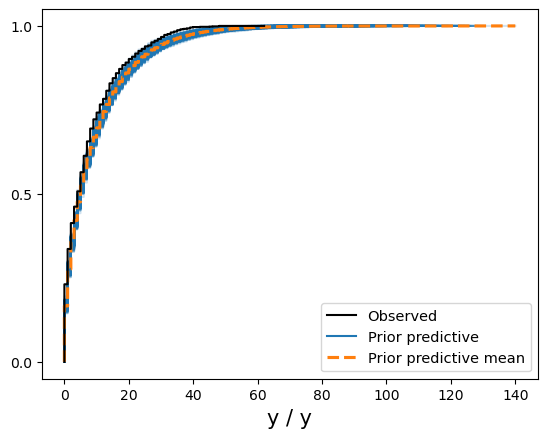

In [74]:
az.plot_ppc(informed_prior_trace, group="prior", kind="cumulative")

In [75]:
with informative_prior_model:
    informed_prior_trace.extend(pm.sample(cores=4, chains=4, random_seed=RANDOM_SEED))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [76]:
informed_means = informed_prior_trace.posterior.mean(dim=("chain", "draw"))
informed_hdi = az.hdi(informed_prior_trace)

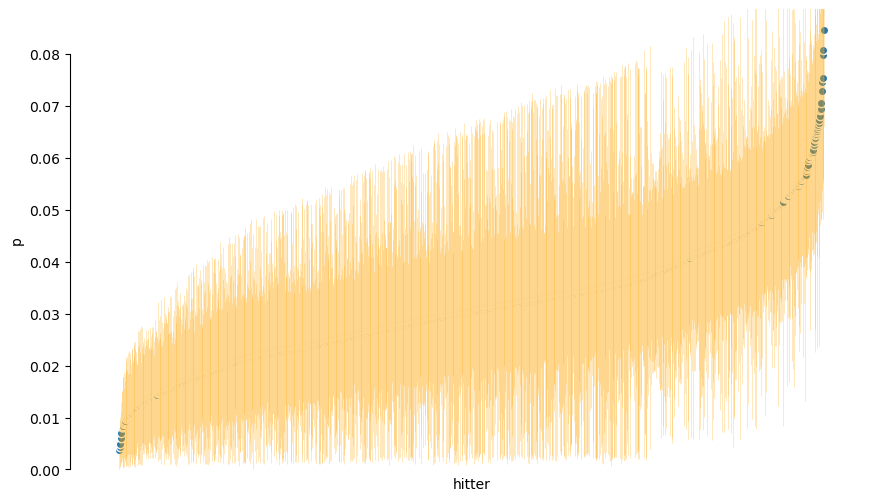

In [77]:
fig, ax = plt.subplots(figsize=(10, 6))

informed_means_iter = informed_means.sortby("p")
informed_hdi_iter = informed_hdi.sortby(informed_means_iter.p)
ax.vlines(
    np.arange(fitting_subset.shape[0]),
    informed_hdi_iter.p.sel(hdi="lower"),
    informed_hdi_iter.p.sel(hdi="higher"),
    color="orange",
    alpha=0.3,
    linewidth=0.6,
)
informed_means_iter.plot.scatter(x="hitter", y="p", ax=ax)

ax.set_xticklabels([])
ax.set_xticks([])
sns.despine(offset=10, trim=True, bottom=True)

(-0.01, 0.28)

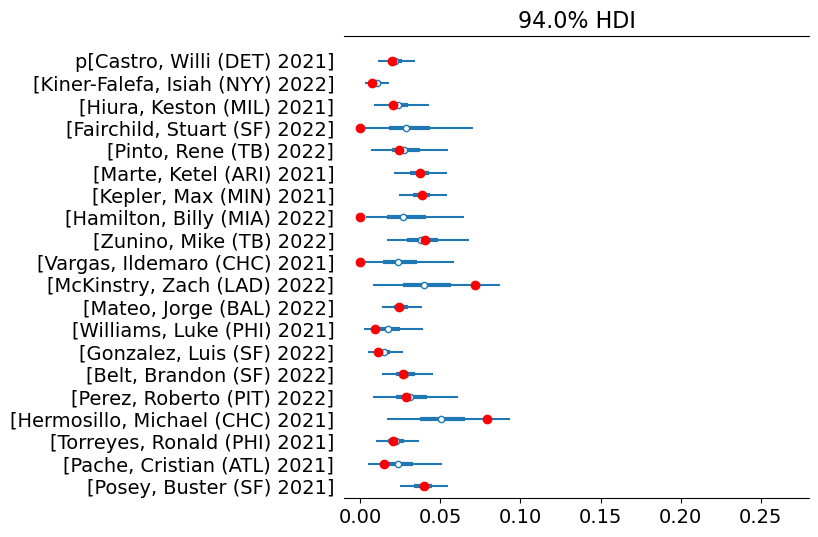

In [82]:
(ax,) = az.plot_forest(
    informed_prior_trace, coords={"hitter": list(SAMPLE_BATTERS)}, combined=True
)
ax.plot(obs_rates[::-1], ax.get_yticks(), "ro")
ax.set_xlim(-0.01, 0.28)

### Multilevel/Hierarchical models
* repeated measures of individual players are correlated. We can improve our model to account for this.
* original assumption: all players are independent
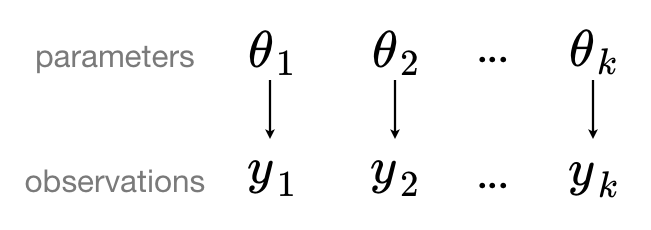

* We can model the player-specific home run rate as a random effect, with a hyperprior distribution that is shared across all players. This is a hierarchical model.

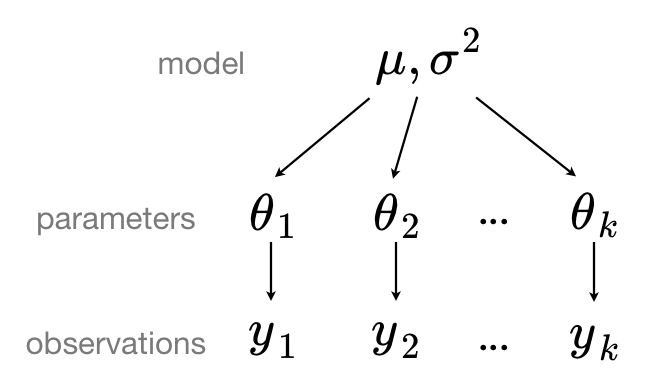

#### Partial pooling model
* A partial pooling model is essentially a weighted average (based on sample size) of a pooled (population mean) and unpooled model.
$$\hat{p} \approx \frac{(n_j/\sigma_j^2)\bar{p}_j + (1/\sigma^2)\bar{p}}{(n_j/\sigma_j^2) + (1/\sigma^2)}$$

/tmp/ipykernel_4092261/1388429980.py:7: RuntimeWarning: divide by zero encountered in divide
  partial_pooled_rates = (rates * (1 / var_rates) + pop_rate * (1 / pop_var)) / (
/tmp/ipykernel_4092261/1388429980.py:7: RuntimeWarning: invalid value encountered in multiply
  partial_pooled_rates = (rates * (1 / var_rates) + pop_rate * (1 / pop_var)) / (
/tmp/ipykernel_4092261/1388429980.py:8: RuntimeWarning: divide by zero encountered in divide
  1 / var_rates + 1 / pop_var


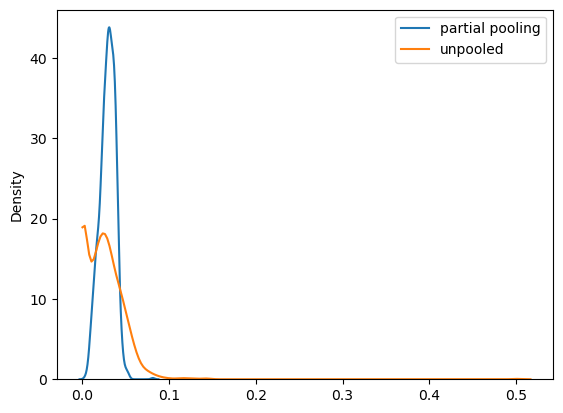

In [94]:
rates = hr / pa  # p_j
var_rates = rates * (1 - rates)  # sigma_j^2

pop_rate = fitting_subset.hr.sum() / fitting_subset.pa.sum()  # p bar
pop_var = pop_rate * (1 - pop_rate)  # sigma^2 (population)

partial_pooled_rates = (rates * (1 / var_rates) + pop_rate * (1 / pop_var)) / (
    1 / var_rates + 1 / pop_var
)

sns.kdeplot(partial_pooled_rates, label="partial pooling")
sns.kdeplot(rates, label="unpooled", clip=(0, 1))
# sns.histplot(partial_pooled_rates, label="partial pooling", bins=70, kde=True)
# sns.histplot(rates, label="unpooled", bins=500, kde=True)
plt.legend()